# Fence Diagrams

This section presents advanced functionality for [`pystrat.Fence`](api/pystrat.rst#pystrat.pystrat.Fence) objects, which permits plotting of fence diagrams with multiple sections.

The example data utilized here comes from the reference listed at the end of the guide. 

The example data files used in this guide can be found [here](https://github.com/pystrat-maintainers/pystrat/tree/main/docs/example-data).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

import pystrat

First load the example data, which is in the **example-data/Fransfontein-fence** directory.

To construct a [`pystrat.Fence`](api/pystrat.rst#pystrat.pystrat.Fence) object, it is necessary to provide a list of `pystrat.Section` objects for the sections that constitue the Fence diagram. 

By default, the order of plotting for the sections corresponds to the order in which they are present in the list of sections (`sections` below). In this case, however, that order is incorrect. The proper order can be ensured by providing an array of the one-dimensional coordinates for each section in the same order as they are present in the `sections` list.

In [2]:
# get section files, in excel spreadsheets
section_files = glob.glob('example-data/Fransfontein-fence/A*.xlsx')

# read spreadsheet with coordinates for each section
coord_df = pd.read_csv('example-data/Fransfontein-fence/coordinates.csv')

# list to hold pystrat.Section objects
sections = []  
# list to hold section coordinates
coordinates = np.zeros(len(section_files))

for ii, section_file in enumerate(section_files):
    # section name
    section_name = os.path.splitext(os.path.basename(section_file))[0] # just take file name as section name
    # read section
    section_df = pd.read_excel(section_file, sheet_name='section')
    # read annotations
    ann_df = pd.read_excel(section_file, sheet_name='annotations')
    # make section
    section = pystrat.Section(section_df['thickness'], 
                              section_df['facies'], 
                              annotations=ann_df, 
                              name=section_name,  
                              units=section_df['formation abbr'].values)
    # add to list of sections
    sections.append(section)
    # find coordinate for current section, and append to list of coordinates
    coordinates[ii] = coord_df.loc[coord_df['section'] == section_name]['coordinate'].squeeze()

With the proper section ordering in `coordinates`, it is now possible to construct the `pystrat.Fence` object.

In [3]:
fence_1 = pystrat.Fence(sections, coordinates=coordinates)

As with `pystrat.Section` objects, it is necessary to specify a `pystrat.Style` to plot the fence diagram.

In [4]:
# styling DataFrame for the fence diagram
style_df = pd.read_csv('example-data/Fransfontein-fence/style.csv')

# create pystrat.Style object
style_1 = pystrat.Style(style_df['lithofacies'], 
                        style_df[['R','G','B']].values/255,
                        style_df['width'])

Plotting `pystrat.Fence` objects involves `matplotlib.pyplot.figure` objects. This behavior differs from the plotting of `pystrat.Section` objects, which go directly into `matplotlib.pyplot.axes` objects.

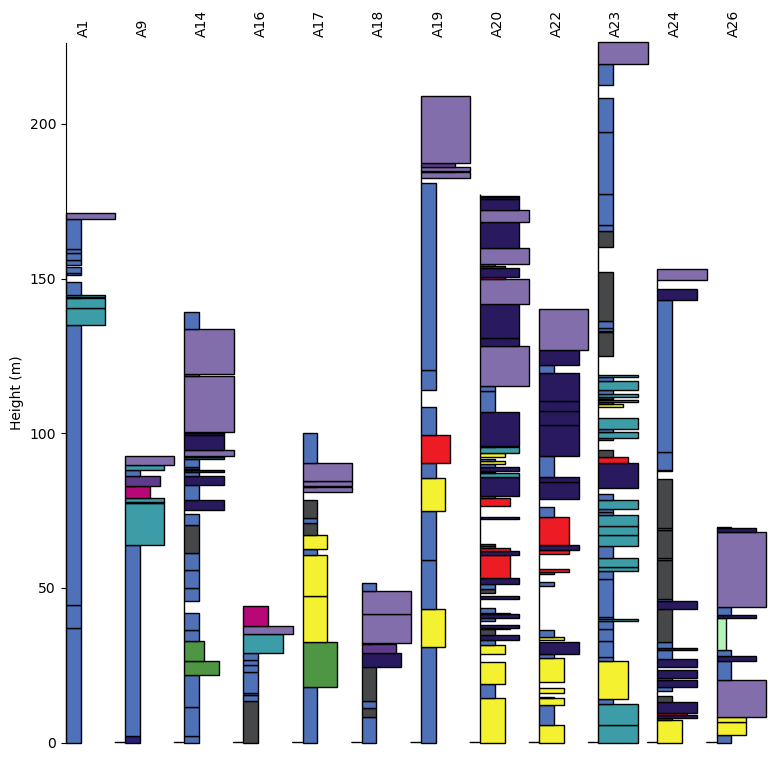

In [5]:
fig = plt.figure(figsize=(7, 7))

fence_1.plot(style_1, fig=fig, col_buffer_fac=0.2)

plt.show()

The fence diagram generated above demonstrates the minimal, default funcationality of `pystrat.Fence`. For more features, continue through the following sections.

## Datum and Correlations

A crucial quantity for fence diagrams is the stratigraphic datum that dictates how sections in the fence diagram should be vertically aligned with respect to each other. 

In `pystrat.Fence`, this quantity is passed as the `datums=` parameter, which specifies the height in each section corresponding to the datum horizon. 

Often, a datum is only one of several correlative horizons. The code below loads in correlative horizons within the sections defined above.

In [6]:
# load all correlative horizons
corr_df = pd.read_csv('example-data/Fransfontein-fence/correlations.csv', index_col=0)

# ensure that datum is ordered according to section order
section_names = [section.name for section in sections]
corr_df = corr_df.reindex(section_names)

# define datum
datums = corr_df['Ghaub'].values

Take care to ensure that the entries in the `datums` object observe the same order as each section in `sections`.

In this case, the datum is defined to be the base of the Ghaub Formation in each section. With the datum so defined, reconstruct the fence object.

In [7]:
fence_2 = pystrat.Fence(sections, coordinates=coordinates, datums=datums)

Now when plotting, the vertical arrangement of the sections will ensure that the datum horizon occurs at the same height for all sections across the fence.

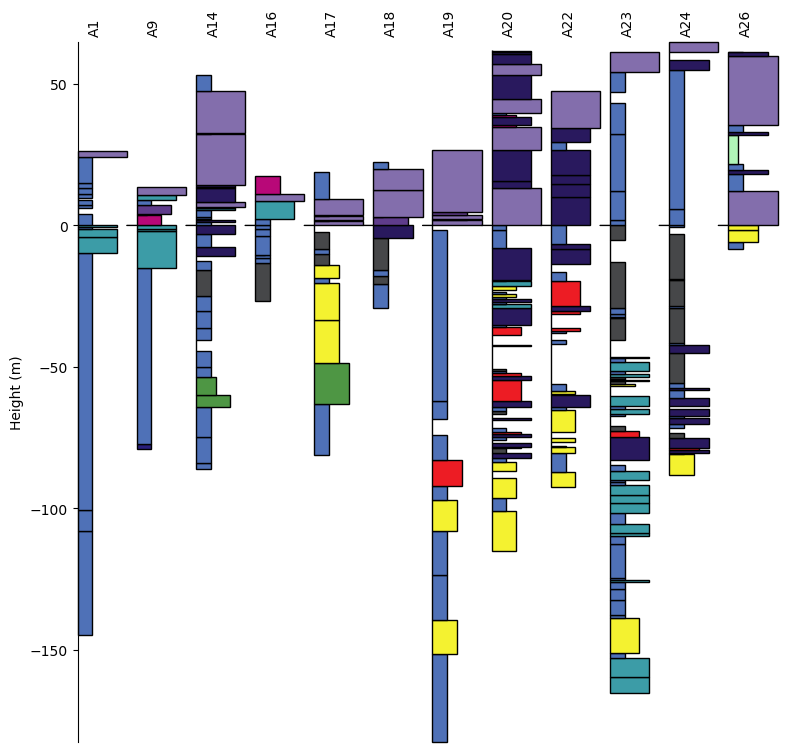

In [8]:
fig = plt.figure(figsize=(7, 7))

fence_2.plot(style_1, fig=fig)

plt.show()

### Correlations

Correlative horizons are often visually shown by drawing lines between the relevant heights for all the sections in a fence diagram. This effect can be achieved in `pystrat` by defining correlative heights in sections similarly as to how the datums are defined above. 

Unlike datums, for which the same horizon must be present in all sections, correlations need not be present in all sections to be drawn. Only correlative horizons present in neighboring sections, however, will be illustrated.

In [9]:
correlations = corr_df[['Franni-aus', 'Narachaams', 'Okonguarri', 'Berg Aukas']].values

In [10]:
fence_3 = pystrat.Fence(sections, coordinates=coordinates, 
                        datums=datums, correlations=correlations)

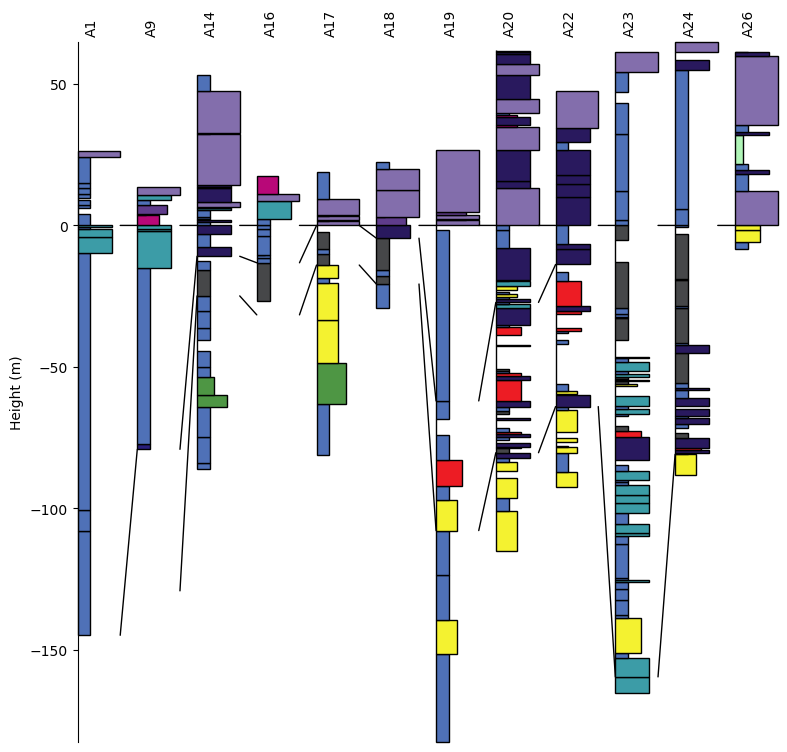

In [11]:
fig = plt.figure(figsize=(7, 7))

fence_3.plot(style_1, fig=fig, col_buffer_fac=0.4)

plt.show()

```{note}
The `col_buffer_frac` parameter allows the user to specify the minimum spacing between adjacent sections in the fence diagram. The spacing is set by the value of `col_buffer_frac` times section width in the fence. For example, a value of `col_buffer_frac=0.5` means that the minimum spacing between sections in the fence will be half of the width of a plotted section.
```

## Section Distances

Often, sections in a fence diagram will be spaced to reflect true geographic distances between sections. This effect can be achieved in `pystrat` using the `distance_spacing=True` parameter during plotting.

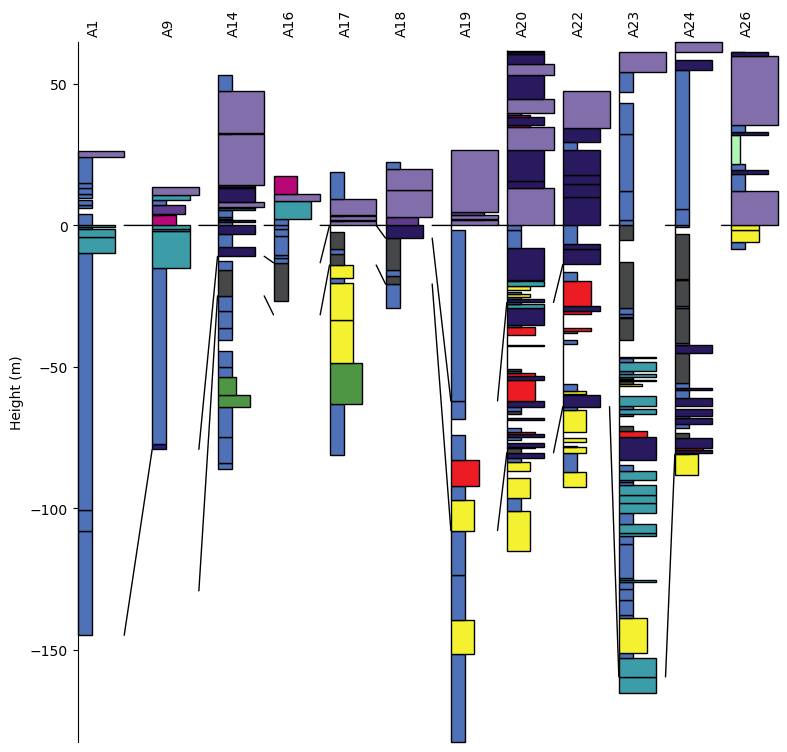

In [12]:
fig = plt.figure(figsize=(7, 7))

fence_3.plot(style_1, fig=fig, distance_spacing=True)

plt.show()

### Schematic Distances

In some cases, realistic distance scaling would result in excessive blank space between distant sections, and the user might instead want to schematically represent relative spacing. 

This result can be achieved in `pystrat` by specifying `plot_distances=` when plotting. `plot_distances` expects an array of distances between sections (with length equal to the number of sections minus 1). 

**Importantly**, the entries of `plot_distances=` must be ordered according to the geographically ordered sections; i.e., according to how the sections are ordered *after* sorting according to `coordinates`. 

In [13]:
plot_distances = [2, 1.5, 1, 1, 1, 1.5, 1, 1, 1, 1, 1]

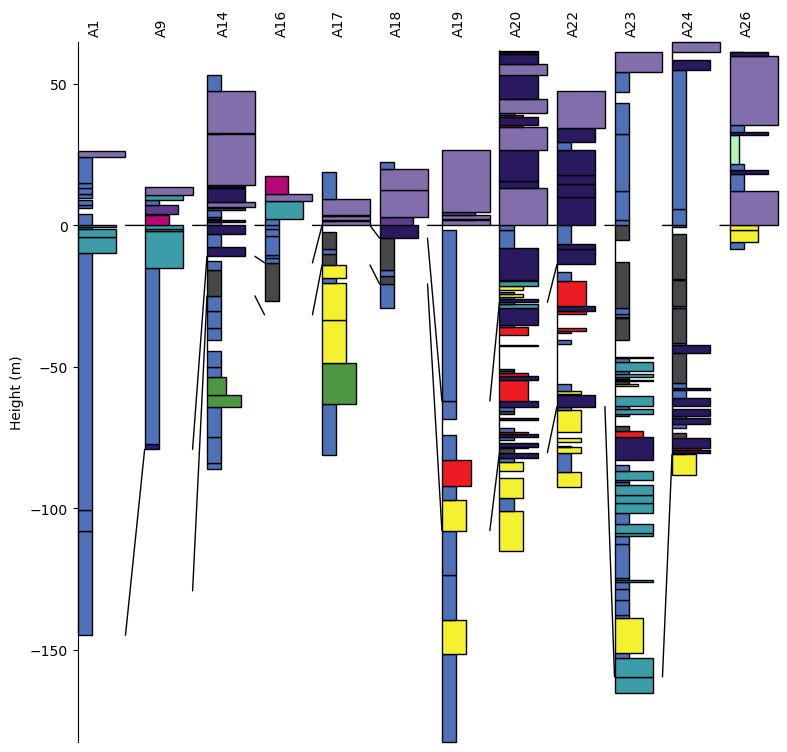

In [14]:
fig = plt.figure(figsize=(7, 7))

fence_3.plot(style_1, fig=fig, distance_spacing=True, plot_distances=plot_distances)

plt.show()

### Distance Labels

Distances between sections in the fence diagram can be labeled by setting the `distance_labels=True` parameter when plotting. Labels appear at the top of the fence diagram in between the section names.

Styling for the distance labels can be passed as a dictionary to the `distance_labels_style=` parameter. The dictionary should contain valid keyword arguments for `matplotlib.pyplot.annotate`.

In [15]:
distance_labels_style = {'fontstyle': 'italic', 'color': 'gray'}

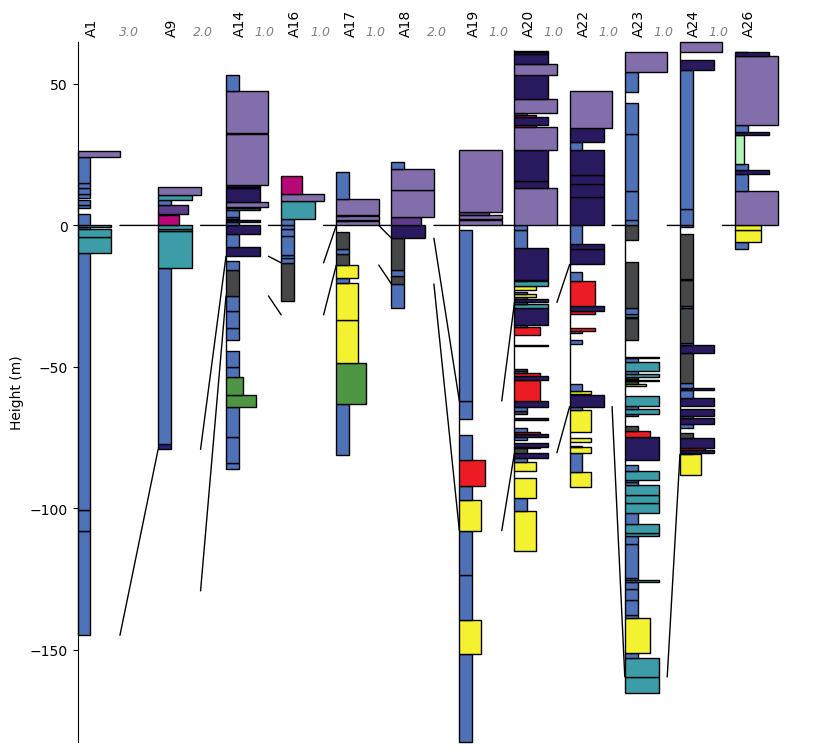

In [16]:
fig = plt.figure(figsize=(7, 7))

fence_3.plot(style_1, fig=fig, col_buffer_fac=0.3,
             distance_spacing=True, distance_labels=True, distance_labels_style=distance_labels_style)

plt.show()

To customize the strings that are plotted as the distance label, the user can instead provide a list or array of strings correponding to each distance.

In [17]:
distances = np.diff(fence_3.coordinates)
distance_labels = [f'{distance:1.0f} km' for distance in distances]

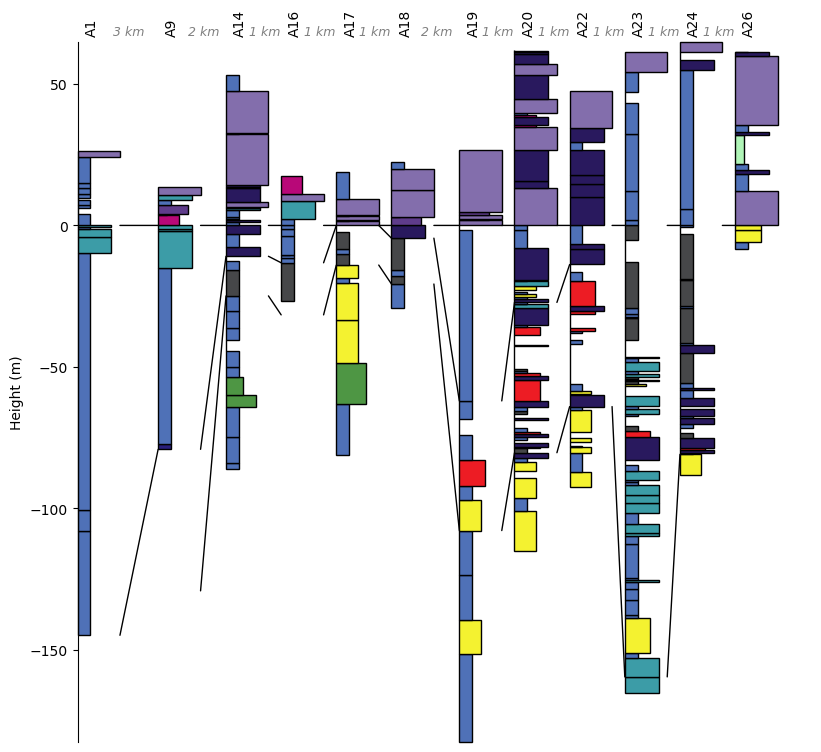

In [18]:
fig = plt.figure(figsize=(7, 7))

fence_3.plot(style_1, fig=fig, col_buffer_fac=0.3,
             distance_spacing=True, distance_labels=distance_labels, distance_labels_style=distance_labels_style)

plt.show()

## Section Plotting Options

Section plotting options can also be specified when plotting fence diagrams. These parameters are passed as a dictionary to the `section_plot_style=` parameter during plotting.

For example, to plot annotations and label units:

In [19]:
# create pystrat.Style object with annotations
style_2 = pystrat.Style(style_df['lithofacies'], 
                        style_df[['R','G','B']].values/255,
                        style_df['width'],
                        annotations=['dropstone', 'geochron'])

In [20]:
section_plot_style = {'label_units': True, 
                      'unit_label_wid_tot': 0.5,
                      'annotation_height': 0.08,
                      'unit_fontsize': 7}

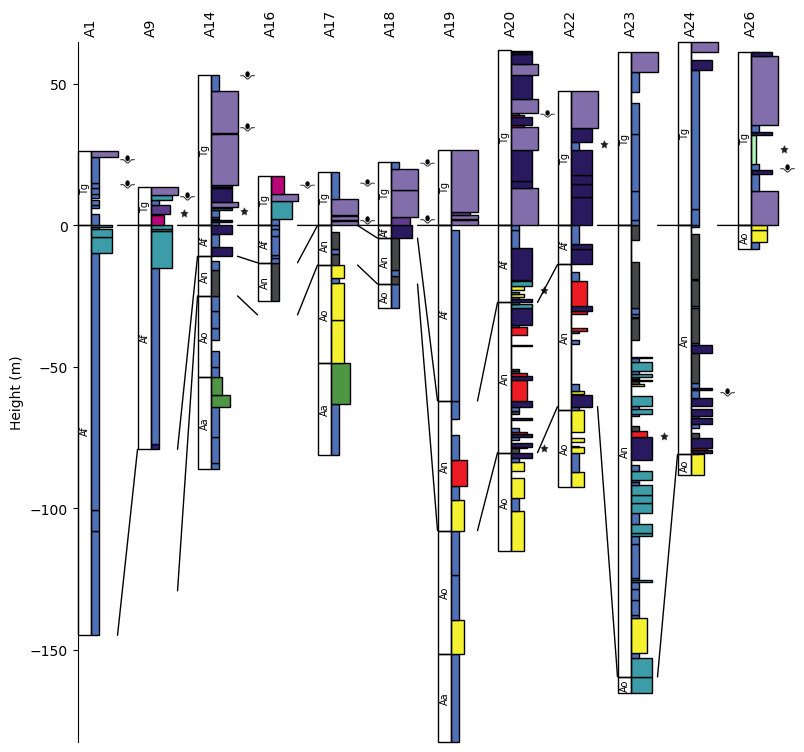

In [21]:
fig = plt.figure(figsize=(7, 7))

fence_3.plot(style_2, fig=fig, section_plot_style=section_plot_style, col_buffer_fac=0.5)

plt.show()

## Stratigraphic Data

It is common to plot stratigraphic datasets within fence diagrams to show how measurements are do or do not covary across the fence. In `pystrat`, plotting stratigraphic data in a fence diagram is straightforward.

Below, $\delta^{13}$C and $\delta^{18}$O measurements from carbonates in the sections shown above are added to each section as data attributes; see [`pystrat.Section` data attributes](sections.ipynb#data-attributes) in the tutorial on section objects.

In [22]:
# load the chemostratigraphic data
chemostrat_df = pd.read_csv('example-data/Fransfontein-fence/chemostratigraphy.csv')

for ii, section_file in enumerate(section_files):
    # section name
    section_name = os.path.splitext(os.path.basename(section_file))[0] # just take file name as section name

    # filter data for current section
    cur_chemostrat_df = chemostrat_df[chemostrat_df['section'] == section_name]

    # add the data to the current section
    sections[ii].add_data_attribute('d13C', 
                                    cur_chemostrat_df['height'].values, 
                                    cur_chemostrat_df['d13C'].values)
    sections[ii].add_data_attribute('d18O', 
                                    cur_chemostrat_df['height'].values, 
                                    cur_chemostrat_df['d18O'].values)

The original section objects are updated by the code above, but note that they are *not* updated in the `fence_1` object. Whenever `pystrat.Section` objects are updated, a new `pystrat.Fence` object must be constructed to incorporate the updates.

In [23]:
fence_4 = pystrat.Fence(sections, coordinates=coordinates, datums=datums)

The plotting style for data attributes can be controlled with the `data_attribute_styles=` parameter, which accepts dictionaries with parameters for `matplotlib.pyplot.plot`. If a single dictionary is provided, the same style is used for all data attributes. Alternatively, each data attribute can be styled differently by providing a list with as many dictionaries as there are data attributes.

In [24]:
d13C_style = {'marker': '.', 'color': 'k', 'markersize': 4, 'linestyle':''}

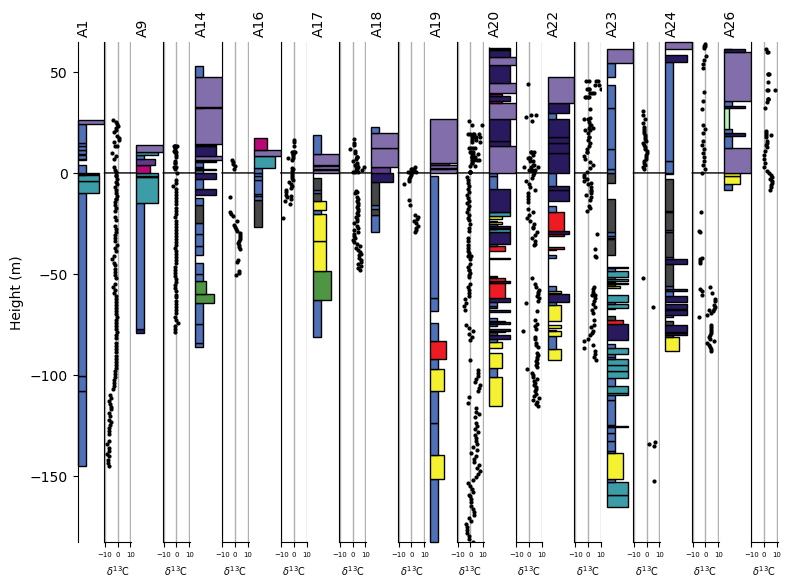

In [25]:
fig = plt.figure(figsize=(7, 5))

# plot fence with data d13C data attribute
axes, axes_dat = fence_4.plot(style_1, fig=fig,
                              data_attributes=['d13C'],
                              data_attribute_styles=[d13C_style])

# adjust the x-axes for the data attribute plots
for ax in axes_dat:
    ax[0].set_xlim([-10.5, 10.5])
    ax[0].tick_params(axis='x', labelsize=5)
    ax[0].set_xlabel('$\\delta^{13}$C', fontsize=7)
    ax[0].grid(axis='x', which='major', linewidth=1)

plt.show()

```{note}
The `pystrat.Fence.plot` function returns handles to both the section and data attribute axes, `axes` and `axes_dat` above. Customization of axes parameters such as grids, labels, limits, etc. can be accomplished through those handles.
```

In [26]:
fence_5 = pystrat.Fence(sections[0:5], coordinates=coordinates[0:5], datums=datums[0:5])

The plotting style for data attributes can be controlled with the `data_attribute_styles=` parameter, which accepts dictionaries with parameters for `matplotlib.pyplot.plot`. If a single dictionary is provided, the same style is used for all data attributes. Alternatively, each data attribute can be styled differently by providing a list with as many dictionaries as there are data attributes.

In [27]:
d13C_style = {'marker': '.', 'color': 'k', 'markersize': 4, 'linestyle':''}
d18O_style = {'marker': 's', 'color': 'r', 'markersize': 3, 'linestyle':''}

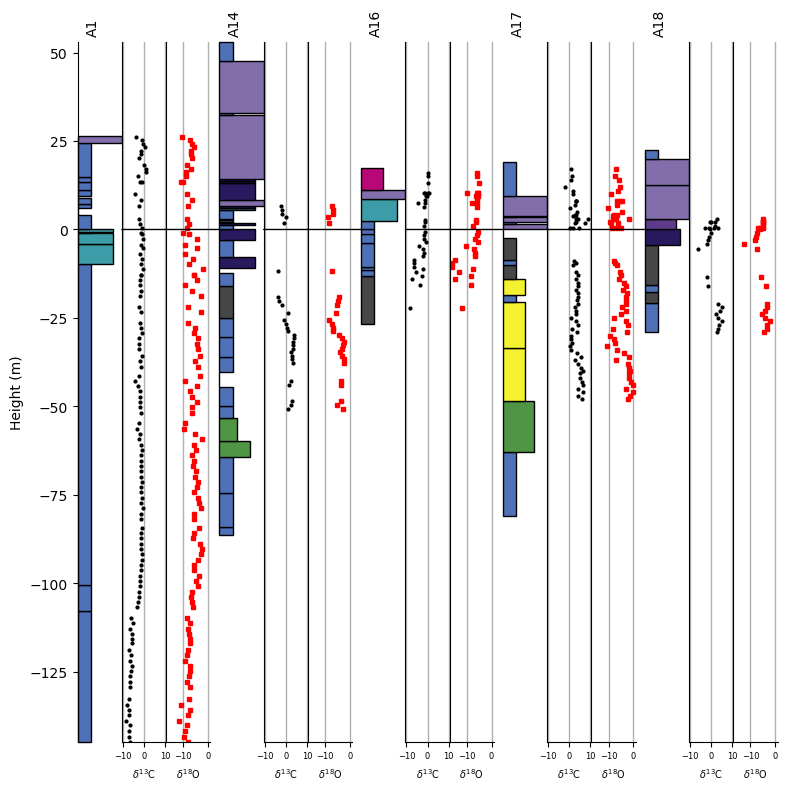

In [28]:
fig = plt.figure(figsize=(7, 7))

# plot fence with data d13C data attribute
axes, axes_dat = fence_5.plot(style_1, fig=fig,
                              data_attributes=['d13C', 'd18O'],
                              data_attribute_styles=[d13C_style, d18O_style],
                              sec_wid=1)

# adjust the x-axes for the data attribute plots
for axs in axes_dat:
    axs[0].set_xlim([-10.5, 10.5])
    axs[1].set_xlim([-17, 1])
    axs[0].set_xlabel('$\\delta^{13}$C', fontsize=7)
    axs[1].set_xlabel('$\\delta^{18}$O', fontsize=7)
    for ax in axs:
        ax.tick_params(axis='x', labelsize=6)
        ax.grid(axis='x', which='major', linewidth=1)

plt.show()

## Plotting Options

Other plotting options can be specified for `pystrat.Fence.plot`.

### Section Title Rotation

Section names rotated vertically by default to accommodate potentially long names and facilitate labeling of distances between sections.

The names can easily be rotated to horizontal, however, by setting `sec_names_rotate=False` when plotting.

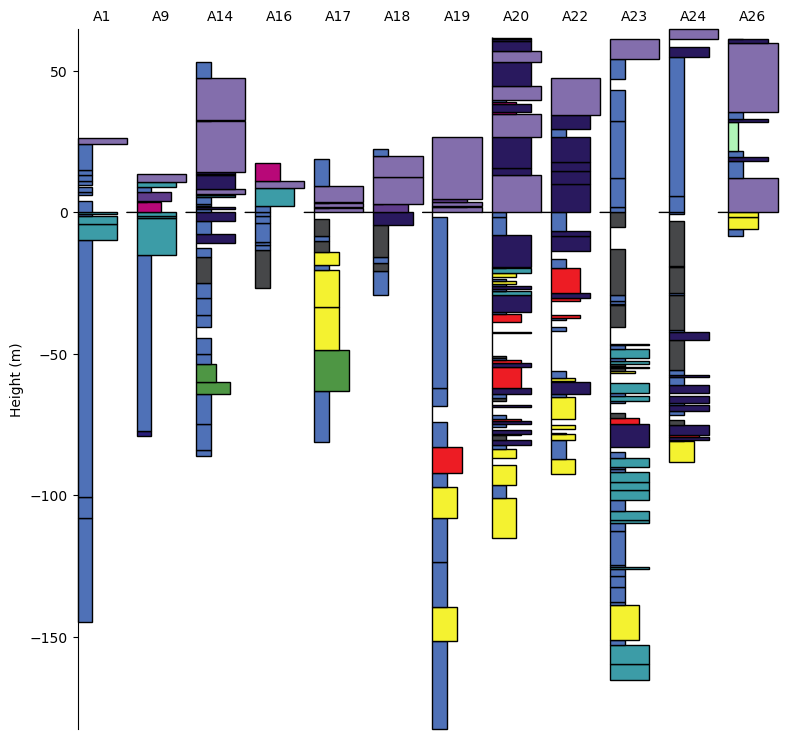

In [29]:
fig = plt.figure(figsize=(7, 7))

fence_2.plot(style_1, fig=fig, sec_names_rotate=False)

plt.show()

## References

> Tasistro-Hart, A.R., Macdonald, F.A., Crowley, J.L., and Schmitz, M.D., 2025, Four-million-year Marinoan snowball shows multiple routes to deglaciation: Proceedings of the National Academy of Sciences, v. 122, p. e2418281122, doi:[10.1073/pnas.2418281122](https://doi.org/10.1073/pnas.2418281122).